In [11]:
################################################################################
# Split and save dataset
################################################################################

import os
import pandas as pd

df_train = pd.read_csv(os.getcwd() + '/data/population_train.csv', low_memory=False)
df_test = pd.read_csv(os.getcwd() + '/data/population_test.csv', low_memory=False)

sample_size = 10000

sample_df_train = pd.concat([
    df_train[df_train['attack'] == 0].sample(n=int(sample_size*0.4), random_state=42, replace=True),
    df_train[df_train['attack'] == 1].sample(n=int(sample_size*0.4), random_state=42)
])

sample_df_test = pd.concat([
    df_test[df_test['attack'] == 0].sample(n=int(sample_size*0.1), random_state=42, replace=True),
    df_test[df_test['attack'] == 1].sample(n=int(sample_size*0.1), random_state=42)
])

print("Length of train dataset: ", len(sample_df_train))
print("Length of test dataset: ", len(sample_df_test))
sample_df_train.to_csv(os.getcwd() + f'/data/sample-{sample_size}-2_train.csv', index=False)
sample_df_test.to_csv(os.getcwd() + f'/data/sample-{sample_size}-2_test.csv', index=False)

Length of train dataset:  8000
Length of test dataset:  2000


Text(0.5, 1.0, 'Record Count')

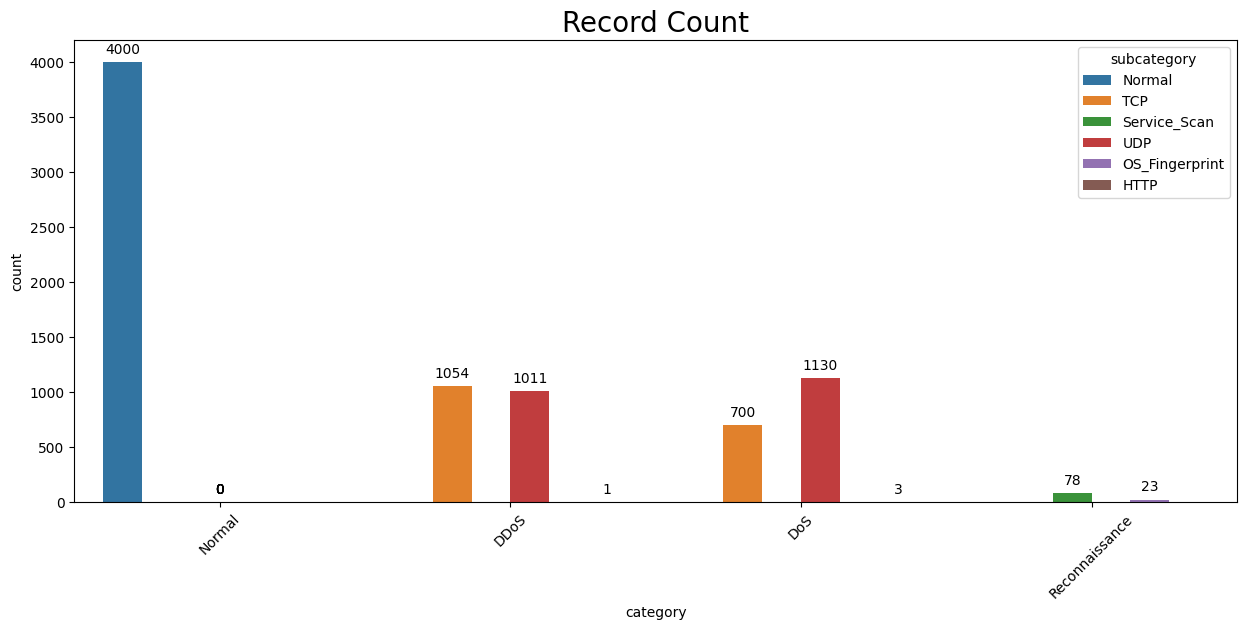

In [14]:
################################################################################
# Class distribution
################################################################################

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sample_size = 10000

saved_sample_df_train = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2_train.csv', low_memory=False)

plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
s = sns.countplot(data=saved_sample_df_train, x='category', hue='subcategory')
for p in s.patches:
    s.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')
plt.title('Record Count', fontsize=20)

# Evaluating Vector Store

In [1]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate

sample_size = 10000

# Load dateset
df_train = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2_train.csv')
df_test = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2_test.csv')

# Split dataset according to attack type and drop columns
normal_df_train = df_train[df_train['attack'] == 0].drop(columns=['attack', 'category', 'subcategory'])
normal_df_test = df_test[df_test['attack'] == 0].drop(columns=['attack', 'category', 'subcategory'])
attack_df_train = df_train[df_train['attack'] == 1].drop(columns=['attack', 'category', 'subcategory'])
attack_df_test = df_test[df_test['attack'] == 1].drop(columns=['attack', 'category', 'subcategory'])

# Print dataset sizes in a table
data = [
    ["Normal", normal_df_train.shape[0] + normal_df_test.shape[0], normal_df_train.shape[0], normal_df_test.shape[0]],
    ["Attack", attack_df_train.shape[0] + attack_df_test.shape[0], attack_df_train.shape[0], attack_df_test.shape[0]]
]
print(tabulate(data, headers=["Atack type", "Total", "Train", "Test"], tablefmt="grid"))

+--------------+---------+---------+--------+
| Atack type   |   Total |   Train |   Test |
+==============+=========+=========+========+
| Normal       |    5000 |    4000 |   1000 |
+--------------+---------+---------+--------+
| Attack       |    5000 |    4000 |   1000 |
+--------------+---------+---------+--------+


In [24]:
################################################################################
# Add documents to vector store
################################################################################

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from tqdm import tqdm

# Initialize embeddings
embeddings = HuggingFaceEmbeddings()

# Initialize vector store
vector_store = Chroma(
    collection_name="bot-iot",
    embedding_function=embeddings, 
    persist_directory=f"./vector-stores/chroma-db-{sample_size}-2")

# Add batched documents to vector store
batch_size = 16
total_normal_documents = normal_df_train.shape[0]
total_attack_documents = attack_df_train.shape[0]

for i in tqdm(range(0, total_normal_documents, batch_size), ncols=100, desc="Adding normal documents to vector store"):
    documents = [Document(page_content=str(normal_df_train.iloc[i+j].to_list()), metadata={"source": "bot-iot", "label": "normal"}) for j in range(min(batch_size, total_normal_documents-i))]
    vector_store.add_documents(documents)

for i in tqdm(range(0, total_attack_documents, batch_size), ncols=100, desc="Adding attack documents to vector store"):
    documents = [Document(page_content=str(attack_df_train.iloc[i+j].to_list()), metadata={"source": "bot-iot", "label": "attack"}) for j in range(min(batch_size, total_attack_documents-i))]
    vector_store.add_documents(documents)

print(f"Total number of documents added: {total_attack_documents+total_normal_documents}")

/opt/home/s4025371/anaconda3/envs/llm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Adding attack documents to vector store: 100%|████████████████████| 250/250 [22:21<00:00,  5.37s/it]

Total number of documents added: 8000


In [2]:
################################################################################
# Predict from Vector Store
################################################################################

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from statistics import mode
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

train_set_size = sample_size

embeddings = HuggingFaceEmbeddings()

vector_store = Chroma(
    collection_name="bot-iot",
    embedding_function=embeddings, 
    persist_directory=f"./vector-stores/chroma-db-{train_set_size}-2")

retriever = vector_store.as_retriever(
    search_type="mmr", 
    search_kwargs={"k": 5, "fetch_k": 5})

datasets = {"normal": normal_df_test, "attack": attack_df_test}
y_pred = []
y_true = []
for attack_type, dataset in datasets.items():
    test_set_size = dataset.shape[0]
    for i in tqdm(range(test_set_size), ncols=100, desc=f"Predicting {attack_type} entries..."):
        query_document = str(dataset.iloc[i].to_list())
        similar_documents = retriever.invoke(query_document, filter={"source": "bot-iot"})
        y_true.append(attack_type)
        y_pred.append(mode([doc.metadata["label"] for doc in similar_documents]))

c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-{sample_size}-2-{train_set_size}.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

/opt/home/s4025371/anaconda3/envs/llm/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/opt/home/s4025371/anaconda3/envs/llm/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Predicting attack entries...: 100%|█████████████████████████████| 1000/1000 [22:51<00:00,  1.37s/it]

              precision    recall  f1-score   support

      attack       0.87      0.99      0.93      1000
      normal       0.99      0.85      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.92      0.92      2000

[[992   8]
 [146 854]]


# Evaluating ML Models

In [11]:
################################################################################
# Load dataset and split it into training and test set
################################################################################

import pandas as pd
import os
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder

sample_size = 10000

# Load dateset
df_train = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2_train.csv')
df_test = pd.read_csv(os.getcwd() + f'/data/sample-{sample_size}-2_test.csv')

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_columns = df_train.select_dtypes(include=['object']).columns
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

# Split dataset according to attack type and drop columns
normal_df_train = df_train[df_train['attack'] == 0]
normal_df_test = df_test[df_test['attack'] == 0]
attack_df_train = df_train[df_train['attack'] == 1]
attack_df_test = df_test[df_test['attack'] == 1]

X_train = pd.concat([normal_df_train, attack_df_train]).drop(columns=['attack', 'category', 'subcategory'])
y_train = pd.concat([normal_df_train, attack_df_train])['attack']
X_test = pd.concat([normal_df_test, attack_df_test]).drop(columns=['attack', 'category', 'subcategory'])
y_test = pd.concat([normal_df_test, attack_df_test])['attack']

print("Training set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])
print(X_train.columns)

Training set size:  8000
Test set size:  2000
Index(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max'],
      dtype='object')


In [12]:
################################################################################
# Predict from Decision Tree model
################################################################################

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = DecisionTreeClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-dt-{sample_size}-2.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

[[1000    0]
 [   0 1000]]


In [13]:
################################################################################
# Predict from Random Forest model
################################################################################

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = RandomForestClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-rf-{sample_size}-2.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

[[1000    0]
 [   0 1000]]


In [14]:
################################################################################
# Predict from Logistic Regression model
################################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-lr-{sample_size}-2.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

[[995   5]
 [  5 995]]


/opt/home/s4025371/anaconda3/envs/llm/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
################################################################################
# Predict from SVM model
################################################################################

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Create an instance of the DecisionTreeClassifier model
model = SVC()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_true = y_test
y_pred = model.predict(X_test)

# Evaluate the model
c_report = classification_report(y_true, y_pred)
c_matrix = confusion_matrix(y_true, y_pred)

with open(f"results/result-svm-{sample_size}-2.txt", "w") as f:
    f.write(f"Classication Report\n{c_report}\n\nConfusion Matrix\n{c_matrix}")

print(c_report)
print(c_matrix)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1000
           1       1.00      0.94      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[1000    0]
 [  65  935]]
